# Today you are a MLE@Samsung Research and your goal is to perform segmentation of cystic regions from OCT images.
## This work is based on the recent publication https://arxiv.org/abs/2008.02952
## This model is adapted from the original codebase in https://github.com/sohiniroych/U-net_using_TF2

# Optical Coherence Tomography (OCT) images represent grayscale images representing the depth of retina. Cystic regions are gaps in the retina as shown below
![image.png](attachment:image.png)

## Yor goal is to segment the cysts (dark gaps) in the images using the U-net model.

# Your Deliverables are as follows:
### 1. Train a u-net model from scratch and test performance on test images for 2 OCT repos.
### 2. Vary the loss function, kernel dialation, depthwise separable kernels and report results.
### 3. Report observations with and without Batch normalization and Dropout at test time.
### 4. If you use Dropout at test time and generate 2-3 test predictions, what do you observe from these predictions? 

# Task 1: Implement U-net model from scratch for the 'cirrus_3' data set. Report performance on test set and save the model as 'unet_cirrus.hdf5'
## [Instructor Led]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [3]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc

In [5]:
#Define Additional loss functions for Task 2
def dice_coef(y_true, y_pred, smooth=1):
    intersection = keras.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.sum(y_true, axis=[1,2,3]) + keras.sum(y_pred, axis=[1,2,3])
    return keras.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [44]:
#Step 2: Define the U-net model
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [45]:
# Redefinition for 5x5 kernels
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = ['accuracy', dice_coef])
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [58]:
# Redefinition for 5x5 kernels with depthwise convolutions
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = DepthwiseConv2D(3, padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = DepthwiseConv2D(3, padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = ['accuracy', dice_coef])
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [71]:
# Redefinition for 5x5 kernels, no batch norm in decoder
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = ['accuracy', dice_coef])
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [84]:
# Redefinition for 5x5 kernels, extra batch norm in decoder
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = ['accuracy', dice_coef])
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [97]:
# Redefinition for 5x5 kernels, training=True in dropout layers
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 5, dilation_rate=2, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = ['accuracy', dice_coef])
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [7]:
#All additional functions for data prep and evaluation are housed in unet_helper_finctions.py
#from unet_helper_functions import *
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Week 7')
from unet_helper_functions import *

## All definitions are now done! Lets start using the functions now...
## B. Call to image data generator, model initialization, followed by model fitting.

In [98]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/cirrus_3/train/'

In [99]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists('./Data/cirrus_3/test/'+'pred'):
    os.makedirs('./Data/cirrus_3/test/'+'pred')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'aug')

In [100]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_349 (Conv2D)             (None, 256, 256, 64) 1664        input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 256, 256, 64) 256         conv2d_349[0][0]                 
__________________________________________________________________________________________________
conv2d_350 (Conv2D)             (None, 256, 256, 64) 102464      batch_normalization_160[0][0]    
______________________________________________________________________________________

In [101]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [102]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1, callbacks=[model_checkpoint, tensorboard_callback])

Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Epoch 1/50
 2/15 [===>..........................] - ETA: 9s - loss: -0.0729 - accuracy: 0.4601 - dice_coef: 0.0729WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2881s vs `on_train_batch_end` time: 0.6785s). Check your callbacks.


15/15 [==============================] - ETA: 0s - loss: -0.0931 - accuracy: 0.3255 - dice_coef: 0.0889
Epoch 00001: loss improved from inf to -0.09306, saving model to unet_cirrus.hdf5
15/15 [==============================] - 19s 1s/step - loss: -0.0931 - accuracy: 0.3255 - dice_coef: 0.0889
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: -0.1470 - accuracy: 0.5519 - dice_coef: 0.1550
Epoch 00002: loss improved from -0.09306 to -0.14696, saving model to unet_cirrus.hdf5
15/15 [==============================] - 15s 987ms/step - loss: -0.1470 - accuracy: 0.5519 - dice_coef: 0.1550
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: -0.4179 - accuracy: 0.9479 - dice_coef: 0.4345
Epoch 00003: loss improved from -0.14696 to -0.41786, saving model to unet_cirrus.hdf5
15/15 [==============================] - 15s 1s/step - loss: -0.4179 - accuracy: 0.9479 - dice_coef: 0.4345
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: -0.5299 - accur

In [ ]:
%tensorboard --logdir logs/fit

## C. Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [103]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/pred/',results)

 2/48 [>.............................] - ETA: 1sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0114s vs `on_predict_batch_end` time: 0.0383s). Check your callbacks.


48/48 [==============================] - 2s 41ms/step


/content/drive/MyDrive/Colab Notebooks/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_168.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/Colab Notebooks/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_165.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/Colab Notebooks/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_157.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/Colab Notebooks/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/pred/bscan_151.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/Colab Notebooks/Week 7/unet_helper_functions.py:119: 

In [104]:
#Step 2: Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

Precision= 0.4224409972518563 Recall= 0.3934644006739411 IoU= 0.2375191496978946 acc= 0.9930397669474283 F1= 0.35502934521514157


# Task 2: Vary kernels (dialated kernels), separable filters, loss function and rerun whole process. Does it improve test performance?
### Enter your results in the table below

|U-net Parameters  (cirrus_3)          | Precision|Recall|IoU   |acc   |F1    |
|--------------------------------------|----------|------|------|------|-------|
|3x3 kernels, binary cross entropy     |0.24835538900162765|0.7491870690002833|0.2245623553621994|0.9848686854044596|0.341344742778606|
5x5 kernels, dilated kernels,dice_coef|0.4224409972518563|0.3934644006739411|0.2375191496978946|0.9930397669474283|0.35502934521514157|
5x5 kernels, dilated, depthwise separable kernels,dice_coef|0.4350959045761156|0.5033050235277282|0.2797362107966381|0.9930785497029623|0.4085315313745504|

## Select the best network parameters for semantic segmentation here and save the best unet_cirrus3.hdf5 model!

# Task 3: Perform transfer learning with 'unet_cirrus3.hdf5' as base weights and retrain on the 'nidek1' data set (lesser epochs). Report the same table as above for the 'nidek1' test data.

In [105]:
# Load pretrained model.
pretrained_model = unet()
pretrained_model.load_weights('unet_cirrus.hdf5')

In [106]:
# Setup the dataset.
PATH_RETRAIN='./Data/nidek_1/train/'
if not os.path.exists(PATH_RETRAIN+'aug'):
    os.makedirs(PATH_RETRAIN+'aug')
    
if not os.path.exists('./Data/nidek_1/test/'+'pred'):
    os.makedirs('./Data/nidek_1/test/'+'pred')    
data_gen = trainGenerator(10,PATH_RETRAIN,'Image','GT',data_gen_args, save_to_dir = PATH_RETRAIN+'aug')

In [107]:
# Retrain on nidek1.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_nidek.hdf5', monitor='loss',verbose=1, save_best_only=True)
pretrained_model.fit(data_gen,steps_per_epoch=15,epochs=10,verbose=1, callbacks=[model_checkpoint, tensorboard_callback])

Found 23 images belonging to 1 classes.
Found 23 images belonging to 1 classes.
Epoch 1/10
 2/15 [===>..........................] - ETA: 9s - loss: -0.4855 - accuracy: 0.9857 - dice_coef: 0.4855WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2759s vs `on_train_batch_end` time: 0.6696s). Check your callbacks.


15/15 [==============================] - ETA: 0s - loss: -0.5019 - accuracy: 0.9877 - dice_coef: 0.5192
Epoch 00001: loss improved from inf to -0.50192, saving model to unet_nidek.hdf5
15/15 [==============================] - 14s 904ms/step - loss: -0.5019 - accuracy: 0.9877 - dice_coef: 0.5192
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: -0.5537 - accuracy: 0.9884 - dice_coef: 0.5733
Epoch 00002: loss improved from -0.50192 to -0.55367, saving model to unet_nidek.hdf5
15/15 [==============================] - 14s 946ms/step - loss: -0.5537 - accuracy: 0.9884 - dice_coef: 0.5733
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: -0.5638 - accuracy: 0.9893 - dice_coef: 0.5500
Epoch 00003: loss improved from -0.55367 to -0.56376, saving model to unet_nidek.hdf5
15/15 [==============================] - 14s 929ms/step - loss: -0.5638 - accuracy: 0.9893 - dice_coef: 0.5500
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: -0.5476 - ac

In [108]:
# Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/nidek_1/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/nidek_1/test/Image/')
#Return model outcome for each test image
results = pretrained_model.predict_generator(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('./Data/nidek_1/test/Image/','./Data/nidek_1/test/pred/',results)

 1/30 [>.............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_predict_batch_end` time: 0.0445s). Check your callbacks.


30/30 [==============================] - 1s 36ms/step


In [109]:
# Evaluate the predicted outcome
gt_path='./Data/nidek_1/test/GT/'
evalResult(gt_path,results)

Precision= 0.29612102575566895 Recall= 0.9893657414466738 IoU= 0.2956455263405727 acc= 0.9429931640625 F1= 0.4398396351753104


|U-net Parameters  (nidek_1)          | Precision|Recall|IoU   |acc   |F1    |
|--------------------------------------|----------|------|------|------|-------|
|3x3 kernels, binary cross entropy     |nan|0.0|0.0|0.969653828938802|0.0|
5x5 kernels, dilated kernels,dice_coef|0.29612102575566895|0.9893657414466738|0.2956455263405727|0.9429931640625|0.4398396351753104|
5x5 kernels, dilated, depthwise separable kernels,dice_coef|nan|0.0|0.0|0.969653828938802|0.0|

# Task 4: Report test data performance on Cirrus3 and Nidek1 for the following:
## A. Remove the BatchNormalization commands and add more batch normalizations after each conv2D layer for decoder networks.
## B. Activate dropout to test data (enable training=True) and create 2 cyst masks for each test image. Comment on the overlap between the cyst masks per image. What do you learn here?

## 4.A.

The best model was 5x5 kernels, dilated kernels, dice_coef. We retrain this model, adding and removing batch normalization and reporting results on cirrus3 and nidek_1.

|U-net Parameters  (cirrus_3)          | Precision|Recall|IoU   |acc   |F1    |
|--------------------------------------|----------|------|------|------|-------|
|5x5 kernels, dilated kernels, dice_coef, no batch normalization|nan|0.0|0.0|0.9931999842325846|0.0|
|5x5 kernels, dilated kernels, dice_coef, extra batch normalization|nan|0.0|0.0|0.9931999842325846|0.0|

|U-net Parameters  (nidek_1)          | Precision|Recall|IoU   |acc   |F1    |
|--------------------------------------|----------|------|------|------|-------|
|5x5 kernels, dilated kernels, dice_coef, no batch normalization|nan|0.0|0.0|0.9931999842325846|0.0|
|5x5 kernels, dilated kernels, dice_coef, extra batch normalization|nan|0.0|0.0|0.9931999842325846|0.0|

We would have to retrain these models several times to make any real conclusions. It seems that we had poor random initializations, so we got useless predictions.

## 4.B.

We change the model to have training=True in dropout layers, and compare two sets of predictions.

In [121]:
# Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/nidek_1/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/nidek_1/test/Image/')
#Return model outcome for each test image
results = pretrained_model.predict_generator(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
if not os.path.exists('./Data/nidek_1/test/pred/dropout1/'):
  os.mkdir('./Data/nidek_1/test/pred/dropout1/')
if not os.path.exists('./Data/nidek_1/test/pred/dropout2/'):
  os.mkdir('./Data/nidek_1/test/pred/dropout2/')
saveResult('./Data/nidek_1/test/Image/','./Data/nidek_1/test/pred/dropout1/',results)
test_gen = testGenerator('./Data/nidek_1/test/Image/')
results = pretrained_model.predict_generator(test_gen,n_i,verbose=1)
saveResult('./Data/nidek_1/test/Image/','./Data/nidek_1/test/pred/dropout2/',results)

 1/30 [>.............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_predict_batch_end` time: 0.0452s). Check your callbacks.


30/30 [==============================] - 1s 37ms/step


 1/30 [>.............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_predict_batch_end` time: 0.0259s). Check your callbacks.


30/30 [==============================] - 1s 35ms/step


/content/drive/MyDrive/Colab Notebooks/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/nidek_1/test/pred/dropout2/bscan_77.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)


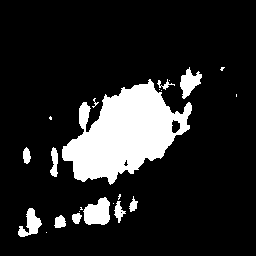

In [122]:
from IPython.display import Image
Image(filename='./Data/nidek_1/test/pred/dropout1/bscan_57.jpg_predict.png')

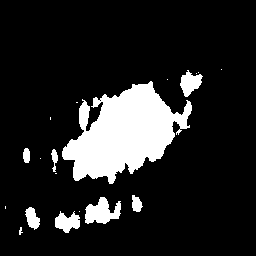

In [123]:
Image(filename='./Data/nidek_1/test/pred/dropout2/bscan_57.jpg_predict.png')

# Conclusion

Model architecture, like many hyperparameters, needs to be tuned with a light touch. Large perturbations will result in poor performance. Models should be tested iteratively, complexity being added slowly.

If dropout is left in even at test time, predictions will be slightly noisy. The overlap between different such predictions on the same inputs shows where the model is most confident, as noise does not disturb the label.
